=== 원본 Cell×SKU 매트릭스 ===
SKU                 1             2             3            4
Cell                                                          
c_Cell1  1.949665e+09  1.452134e+09  0.000000e+00  527245414.0
c_Cell2  0.000000e+00  3.803350e+08  0.000000e+00  608734263.0
c_Cell3  0.000000e+00  1.463042e+08  5.661361e+08          0.0
c_Cell4  0.000000e+00  0.000000e+00  1.408370e+09  837333608.0

👉 병목 Cell: c_Cell1 (총 3929044483, 전체 49.9%)

=== 재분배 후 Cell×SKU 매트릭스 ===
SKU                 1             2             3             4
Cell                                                           
c_Cell1  1.949665e+09  0.000000e+00  0.000000e+00  0.000000e+00
c_Cell2  0.000000e+00  1.106402e+09  0.000000e+00  8.723570e+08
c_Cell3  0.000000e+00  8.723713e+08  5.661361e+08  0.000000e+00
c_Cell4  0.000000e+00  0.000000e+00  1.408370e+09  1.100956e+09

=== 재분배 전 Cell별 SKU 비율 ===
SKU          1      2      3      4
c_Cell1  0.496  0.370  0.000  0.134
c_Cell2  0.000  0.385  0.000  0.615
c_C

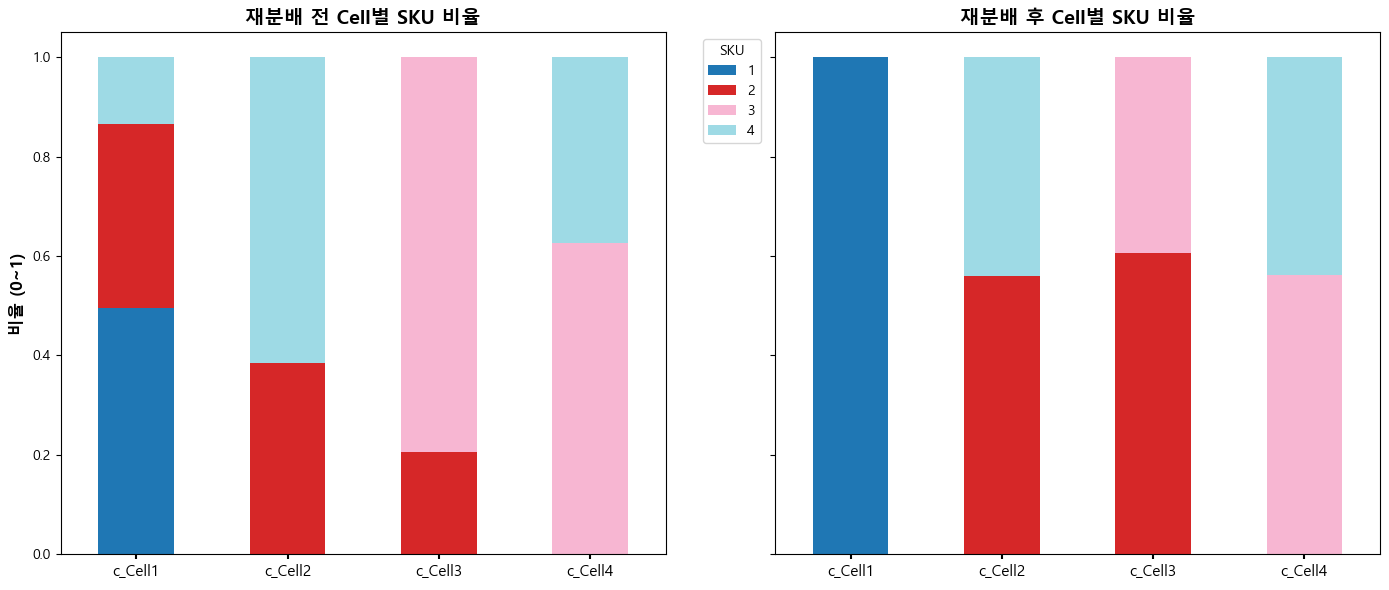

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# ✅ 한글 폰트 (Windows: Malgun Gothic, macOS: AppleGothic, Linux: NanumGothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ========================
# 1. 데이터 불러오기
# ========================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ========================
# 2. Cell ↔ SKU 매핑
# ========================
cell_sku_map = {
    "c_Cell1": [1, 2, 4],
    "c_Cell2": [2, 4],
    "c_Cell3": [2, 3],
    "c_Cell4": [3, 4],
}

# ========================
# 3. Cell×SKU 매트릭스 만들기
# ========================
cell_sku_cols = [c for c in df.columns if c.startswith("c_Cell")]
pivot = df[cell_sku_cols].sum().reset_index()
pivot.columns = ["col", "value"]
pivot["Cell"] = pivot["col"].str.extract(r"(c_Cell\d+)")
pivot["SKU"] = pivot["col"].str.extract(r"SKU(\d+)")

cell_sku_pivot = pivot.pivot_table(
    index="Cell", columns="SKU", values="value", aggfunc="sum"
).fillna(0)

print("=== 원본 Cell×SKU 매트릭스 ===")
print(cell_sku_pivot)

# ========================
# 4. 재분배 로직
# ========================
def redistribute_sku(cell_sku_pivot, cell_sku_map):
    redistributed = cell_sku_pivot.copy().astype(float)

    # 병목 Cell = 총합이 가장 큰 Cell
    cell_totals = redistributed.sum(axis=1)
    bneck_cell = cell_totals.idxmax()

    print(f"\n👉 병목 Cell: {bneck_cell} "
          f"(총 {cell_totals[bneck_cell]:.0f}, 전체 {cell_totals[bneck_cell]/cell_totals.sum():.1%})")

    sku_dist = redistributed.loc[bneck_cell]
    for sku, qty in sku_dist.items():
        if qty == 0:
            continue
        sku_num = int(sku)

        eligible_cells = [
            c for c, skus in cell_sku_map.items()
            if sku_num in skus and c != bneck_cell
        ]
        if not eligible_cells:
            continue

        share = qty / len(eligible_cells)
        redistributed.loc[bneck_cell, sku] -= qty
        for c in eligible_cells:
            redistributed.loc[c, sku] += share

    return redistributed

redistributed = redistribute_sku(cell_sku_pivot, cell_sku_map)

print("\n=== 재분배 후 Cell×SKU 매트릭스 ===")
print(redistributed)

# ========================
# 5. Cell별 SKU 비율 계산
# ========================
def compute_cell_sku_ratios(matrix_before, matrix_after):
    ratios_before = {}
    ratios_after = {}

    for cell in matrix_before.index:
        total_before = matrix_before.loc[cell].sum()
        total_after = matrix_after.loc[cell].sum()

        ratios_before[cell] = (
            (matrix_before.loc[cell] / total_before).round(3) if total_before > 0 else 0
        )
        ratios_after[cell] = (
            (matrix_after.loc[cell] / total_after).round(3) if total_after > 0 else 0
        )

    return pd.DataFrame(ratios_before).T, pd.DataFrame(ratios_after).T

before_ratio, after_ratio = compute_cell_sku_ratios(cell_sku_pivot, redistributed)

print("\n=== 재분배 전 Cell별 SKU 비율 ===")
print(before_ratio)
print("\n=== 재분배 후 Cell별 SKU 비율 ===")
print(after_ratio)

# ========================
# 6. 시각화 (Before vs After 비교)
# ========================
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

before_ratio.plot(kind="bar", stacked=True, ax=axes[0], colormap="tab20")
axes[0].set_title("재분배 전 Cell별 SKU 비율", fontsize=14, fontweight="bold")
axes[0].set_ylabel("비율 (0~1)", fontsize=12, fontweight="bold")
axes[0].tick_params(axis="x", labelrotation=0, labelsize=11, width=1.5)

after_ratio.plot(kind="bar", stacked=True, ax=axes[1], colormap="tab20")
axes[1].set_title("재분배 후 Cell별 SKU 비율", fontsize=14, fontweight="bold")
axes[1].tick_params(axis="x", labelrotation=0, labelsize=11, width=1.5)

# 범례는 오른쪽에만 표시
axes[0].legend(title="SKU", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1].legend().remove()

plt.tight_layout()
plt.show()


=== Cell별 하루 평균 Queue 수 ===
c_Cell1   190.86
c_Cell2    18.56
c_Cell3    70.91
c_Cell4    77.50
dtype: float64


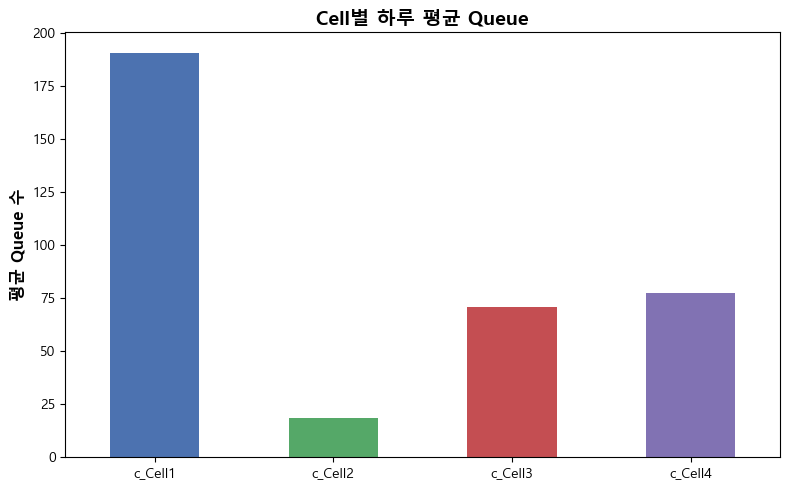

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 한글 폰트 (Windows: Malgun Gothic, macOS: AppleGothic, Linux: NanumGothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ========================
# 1. 데이터 불러오기
# ========================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ========================
# 2. Warehouse Queue → Cell Queue 매핑
# ========================
queue_map = {
    "Warehouse1_Queue": "c_Cell1",
    "Warehouse_2_Queue": "c_Cell2",
    "Warehouse_3_Queue": "c_Cell3",
    "Warehouse_4_Queue": "c_Cell4",
}

# 매핑된 DataFrame 만들기
queue_df = df[list(queue_map.keys())].rename(columns=queue_map)

# ========================
# 3. Cell별 평균 Queue 계산
# ========================
avg_queue = queue_df.mean()

print("\n=== Cell별 하루 평균 Queue 수 ===")
print(avg_queue)

# ========================
# 4. 막대그래프 시각화
# ========================
fig, ax = plt.subplots(figsize=(8, 5))
avg_queue.plot(kind="bar", ax=ax, color=["#4C72B0", "#55A868", "#C44E52", "#8172B3"])
ax.set_title("Cell별 하루 평균 Queue", fontsize=14, fontweight="bold")
ax.set_ylabel("평균 Queue 수", fontsize=12, fontweight="bold")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()
plt.show()


=== 재분배 전 Cell별 평균 Queue (원본) ===
c_Cell1   190.86
c_Cell2    18.56
c_Cell3    70.91
c_Cell4    77.50
dtype: float64

=== 재분배 후 Cell별 평균 Queue (생산량 비율 기반) ===
Cell
c_Cell1    88.58
c_Cell2    89.90
c_Cell3    65.35
c_Cell4   114.00
dtype: float64


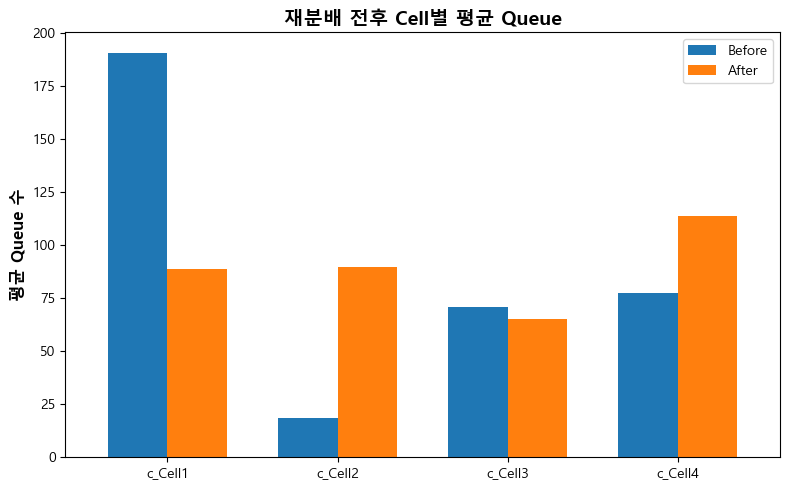

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 한글 폰트 (Windows: Malgun Gothic, macOS: AppleGothic, Linux: NanumGothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ========================
# 1. 데이터 불러오기
# ========================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ========================
# 2. 생산량 데이터 (Cell×SKU 매트릭스)
# ========================
cell_sku_cols = [c for c in df.columns if c.startswith("c_Cell")]
pivot = df[cell_sku_cols].sum().reset_index()
pivot.columns = ["col", "value"]
pivot["Cell"] = pivot["col"].str.extract(r"(c_Cell\d+)")
pivot["SKU"]  = pivot["col"].str.extract(r"SKU(\d+)")

cell_sku_pivot = pivot.pivot_table(
    index="Cell", columns="SKU", values="value", aggfunc="sum"
).fillna(0)

# ========================
# 3. 재분배 로직 (생산량 기준)
# ========================
cell_sku_map = {
    "c_Cell1": [1, 2, 4],
    "c_Cell2": [2, 4],
    "c_Cell3": [2, 3],
    "c_Cell4": [3, 4],
}

def redistribute_sku(cell_sku_pivot, cell_sku_map):
    redistributed = cell_sku_pivot.copy().astype(float)
    cell_totals = redistributed.sum(axis=1)
    bneck_cell = cell_totals.idxmax()  # 병목 Cell

    sku_dist = redistributed.loc[bneck_cell]
    for sku, qty in sku_dist.items():
        if qty == 0:
            continue
        sku_num = int(sku)
        eligible_cells = [
            c for c, skus in cell_sku_map.items()
            if sku_num in skus and c != bneck_cell
        ]
        if not eligible_cells:
            continue
        share = qty / len(eligible_cells)
        redistributed.loc[bneck_cell, sku] -= qty
        for c in eligible_cells:
            redistributed.loc[c, sku] += share
    return redistributed

redistributed = redistribute_sku(cell_sku_pivot, cell_sku_map)

# ========================
# 4. Cell별 생산량 합계 → 비중
# ========================
before_prod = cell_sku_pivot.sum(axis=1)
after_prod  = redistributed.sum(axis=1)

before_ratio = before_prod / before_prod.sum()
after_ratio  = after_prod / after_prod.sum()

# ========================
# 5. Queue 데이터 (Warehouse → Cell 매핑)
# ========================
queue_map = {
    "Warehouse1_Queue": "c_Cell1",
    "Warehouse_2_Queue": "c_Cell2",
    "Warehouse_3_Queue": "c_Cell3",
    "Warehouse_4_Queue": "c_Cell4",
}
queue_df = df[list(queue_map.keys())].rename(columns=queue_map)

# ✅ 재분배 전 Queue = 원본 그대로 평균
before_queue = queue_df.mean()

# ✅ 재분배 후 Queue = 생산량 비율로 분배 (총합은 동일)
total_queue = before_queue.sum()
after_queue = after_ratio * total_queue

print("\n=== 재분배 전 Cell별 평균 Queue (원본) ===")
print(before_queue.round(2))
print("\n=== 재분배 후 Cell별 평균 Queue (생산량 비율 기반) ===")
print(after_queue.round(2))

# ========================
# 6. 시각화
# ========================
fig, ax = plt.subplots(figsize=(8, 5))
pd.DataFrame({"Before": before_queue, "After": after_queue}).plot(
    kind="bar", ax=ax, width=0.7
)
ax.set_title("재분배 전후 Cell별 평균 Queue", fontsize=14, fontweight="bold")
ax.set_ylabel("평균 Queue 수", fontsize=12, fontweight="bold")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()
plt.show()

In [12]:
def redistribute_sku_js_style(cell_sku_pivot):
    redistributed = cell_sku_pivot.copy().astype(float)

    # 1) 셀별 총합
    cell_totals = redistributed.sum(axis=1)
    total_prod = cell_totals.sum()
    avg_per_cell = total_prod / len(cell_totals)

    # 2) 병목 셀 찾기
    bneck_cell = cell_totals.idxmax()
    excess_total = cell_totals[bneck_cell] - avg_per_cell

    # 3) 초과분 있을 때만 재분배
    if excess_total > 0:
        # 병목 Cell 내 SKU별 비율
        sku_dist = redistributed.loc[bneck_cell]
        bneck_sum = sku_dist.sum()

        for sku, qty in sku_dist.items():
            if qty == 0:
                continue

            sku_excess_ratio = qty / bneck_sum   # SKU 비율
            sku_excess = excess_total * sku_excess_ratio

            # 병목 Cell에서 초과분만큼 감소
            redistributed.loc[bneck_cell, sku] -= sku_excess

            # 나머지 셀에 균등 분배
            other_cells = [c for c in redistributed.index if c != bneck_cell]
            share = sku_excess / len(other_cells)
            for c in other_cells:
                redistributed.loc[c, sku] += share

    return redistributed

# 기존 cell_sku_pivot 준비 과정은 동일
redistributed = redistribute_sku_js_style(cell_sku_pivot)

print("\n=== 재분배 후 Cell×SKU 매트릭스 (JS 방식) ===")
print(redistributed)

before_totals = cell_sku_pivot.sum(axis=1)
after_totals  = redistributed.sum(axis=1)

print("\n=== 재분배 전 Cell별 합계 ===")
print(before_totals)
print("\n=== 재분배 후 Cell별 합계 ===")
print(after_totals)


=== 재분배 후 Cell×SKU 매트릭스 (JS 방식) ===
SKU                1            2             3            4
Cell                                                        
c_Cell1 977086289.29 727745780.20          0.00 264232211.26
c_Cell2 324192866.90 621797774.60          0.00 696405330.58
c_Cell3 324192866.90 387766967.60  566136099.00  87671067.58
c_Cell4 324192866.90 241462799.60 1408369527.00 925004675.58

=== 재분배 전 Cell별 합계 ===
Cell
c_Cell1   3929044483.00
c_Cell2    989069238.00
c_Cell3    712440267.00
c_Cell4   2245703135.00
dtype: float64

=== 재분배 후 Cell별 합계 ===
Cell
c_Cell1   1969064280.75
c_Cell2   1642395972.08
c_Cell3   1365767001.08
c_Cell4   2899029869.08
dtype: float64


In [14]:
import pandas as pd

# ========================
# 1. 원본 Queue 데이터 (Warehouse → Cell 매핑)
# ========================
queue_map = {
    "Warehouse1_Queue": "c_Cell1",
    "Warehouse_2_Queue": "c_Cell2",
    "Warehouse_3_Queue": "c_Cell3",
    "Warehouse_4_Queue": "c_Cell4",
}
queue_df = df[list(queue_map.keys())].rename(columns=queue_map)

# ✅ Before Queue = 원본 평균
before_queue = queue_df.mean()

# ========================
# 2. JS 방식 Queue 재분배 로직
# ========================
def redistribute_queue_js_style(before_queue):
    after_queue = before_queue.copy().astype(float)

    total = before_queue.sum()
    avg = total / len(before_queue)

    # 병목 Cell 찾기
    bneck_cell = before_queue.idxmax()
    excess = before_queue[bneck_cell] - avg

    if excess > 0:
        # 병목 Cell 평균 수준까지 감소
        after_queue[bneck_cell] = avg

        # 나머지 Cell에 균등 분배
        other_cells = [c for c in before_queue.index if c != bneck_cell]
        share = excess / len(other_cells)
        for c in other_cells:
            after_queue[c] += share

    return after_queue

after_queue = redistribute_queue_js_style(before_queue)

print("\n=== 재분배 전 Cell별 평균 Queue (원본) ===")
print(before_queue.round(2))

print("\n=== 재분배 후 Cell별 평균 Queue (JS 방식) ===")
print(after_queue.round(2))


=== 재분배 전 Cell별 평균 Queue (원본) ===
c_Cell1   190.86
c_Cell2    18.56
c_Cell3    70.91
c_Cell4    77.50
dtype: float64

=== 재분배 후 Cell별 평균 Queue (JS 방식) ===
c_Cell1    89.46
c_Cell2    52.36
c_Cell3   104.71
c_Cell4   111.30
dtype: float64


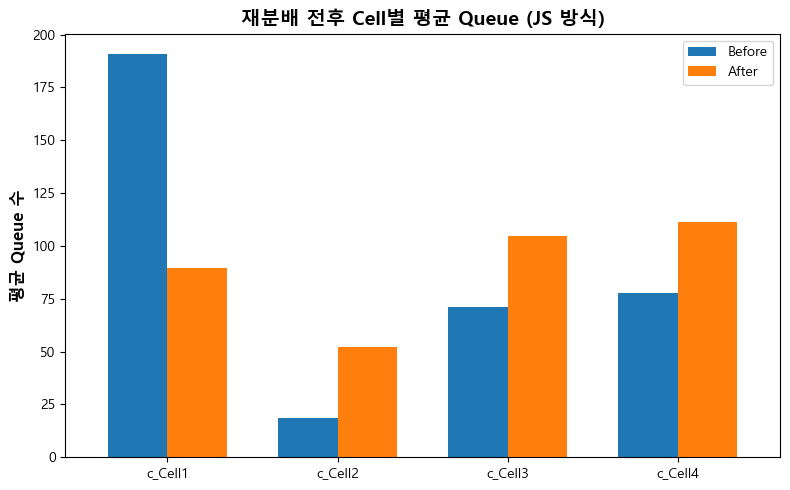

In [15]:
# ========================
# 3. 시각화 (막대그래프)
# ========================
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(8, 5))
pd.DataFrame({"Before": before_queue, "After": after_queue}).plot(
    kind="bar", ax=ax, width=0.7
)
ax.set_title("재분배 전후 Cell별 평균 Queue (JS 방식)", fontsize=14, fontweight="bold")
ax.set_ylabel("평균 Queue 수", fontsize=12, fontweight="bold")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()
plt.show()

# 필요한 것만


=== 재분배 전 Cell별 평균 Queue (원본) ===
c_Cell1   190.86
c_Cell2    18.56
c_Cell3    70.91
c_Cell4    77.50
dtype: float64

=== 재분배 후 Cell별 평균 Queue (JS 방식) ===
c_Cell1    89.46
c_Cell2    52.36
c_Cell3   104.71
c_Cell4   111.30
dtype: float64


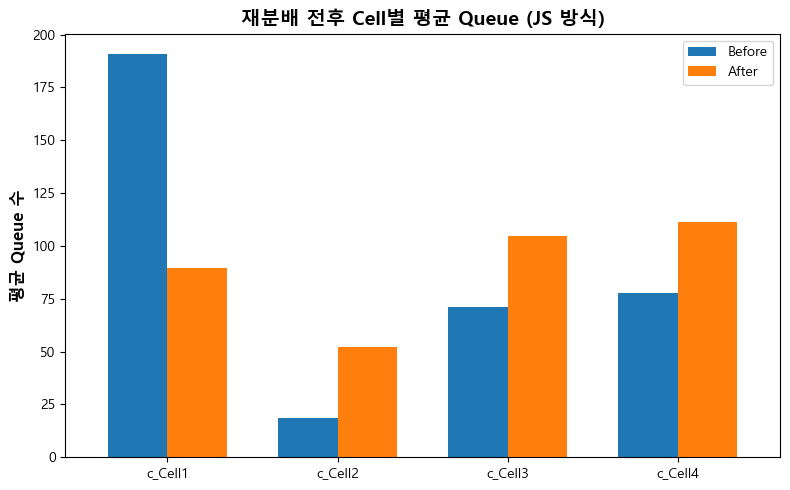

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ========================
# 1. 데이터 불러오기
# ========================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ========================
# 2. Warehouse Queue → Cell Queue 매핑
# ========================
queue_map = {
    "Warehouse1_Queue": "c_Cell1",
    "Warehouse_2_Queue": "c_Cell2",
    "Warehouse_3_Queue": "c_Cell3",
    "Warehouse_4_Queue": "c_Cell4",
}
queue_df = df[list(queue_map.keys())].rename(columns=queue_map)

# ✅ Before Queue = 원본 평균
before_queue = queue_df.mean()

# ========================
# 3. JS 방식 Queue 재분배 로직
# ========================
def redistribute_queue_js_style(before_queue):
    after_queue = before_queue.copy().astype(float)

    total = before_queue.sum()
    avg = total / len(before_queue)

    # 병목 Cell 찾기
    bneck_cell = before_queue.idxmax()
    excess = before_queue[bneck_cell] - avg

    if excess > 0:
        # 병목 Cell을 평균 수준까지 줄임
        after_queue[bneck_cell] = avg

        # 초과분을 나머지 Cell에 균등 분배
        other_cells = [c for c in before_queue.index if c != bneck_cell]
        share = excess / len(other_cells)
        for c in other_cells:
            after_queue[c] += share

    return after_queue

after_queue = redistribute_queue_js_style(before_queue)

# ========================
# 4. 결과 출력
# ========================
print("\n=== 재분배 전 Cell별 평균 Queue (원본) ===")
print(before_queue.round(2))

print("\n=== 재분배 후 Cell별 평균 Queue (JS 방식) ===")
print(after_queue.round(2))

# ========================
# 5. 시각화 (막대그래프)
# ========================
fig, ax = plt.subplots(figsize=(8, 5))
pd.DataFrame({"Before": before_queue, "After": after_queue}).plot(
    kind="bar", ax=ax, width=0.7
)
ax.set_title("재분배 전후 Cell별 평균 Queue (JS 방식)", fontsize=14, fontweight="bold")
ax.set_ylabel("평균 Queue 수", fontsize=12, fontweight="bold")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()
plt.show()